# 2A.ml - Réduction d'une forêt aléatoire - correction

Le modèle Lasso permet de sélectionner des variables, une forêt aléatoire produit une prédiction comme étant la moyenne d'arbres de régression. Et si on mélangeait les deux ?

In [10]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

In [11]:
%matplotlib inline

## Datasets

Comme il faut toujours des données, on prend ce jeu [Boston](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_boston.html).

In [12]:
from sklearn.datasets import load_boston
data = load_boston()
X, y = data.data, data.target

In [13]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [14]:
data.feature_names

array(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD',
       'TAX', 'PTRATIO', 'B', 'LSTAT'], dtype='<U7')

## Une forêt aléatoire

In [15]:
from sklearn.ensemble import RandomForestRegressor as model_class
clr = model_class()
clr.fit(X_train, y_train)

C:\Users\m_pic\AppData\Roaming\Python\Python37\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

Le nombre d'arbres est...

In [16]:
len(clr.estimators_)

10

In [17]:
from sklearn.metrics import r2_score
r2_score(y_test, clr.predict(X_test))

0.8804126619579686

## Random Forest = moyenne des prédictions

On recommence en faisant la moyenne soi-même.

In [18]:
import numpy
dest = numpy.zeros((X_test.shape[0], len(clr.estimators_)))
estimators = numpy.array(clr.estimators_).ravel()
for i, est in enumerate(estimators):
    pred = est.predict(X_test)
    dest[:, i] = pred

average = numpy.mean(dest, axis=1)
r2_score(y_test, average)

0.8804126619579686

A priori, c'est la même chose.

## Pondérer les arbres à l'aide d'une régression linéaire

La forêt aléatoire est une façon de créer de nouvelles features, 100 exactement qu'on utilise pour caler une régression linéaire.

In [19]:
from sklearn.linear_model import LinearRegression


def new_features(forest, X):
    dest = numpy.zeros((X.shape[0], len(forest.estimators_)))
    estimators = numpy.array(forest.estimators_).ravel()
    for i, est in enumerate(estimators):
        pred = est.predict(X)
        dest[:, i] = pred
    return dest


X_train_2 = new_features(clr, X_train)
lr = LinearRegression()
lr.fit(X_train_2, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [20]:
X_test_2 = new_features(clr, X_test)
r2_score(y_test, lr.predict(X_test_2))

0.8744598686290768

Un peu moins bien, un peu mieux, le risque d'overfitting est un peu plus grand avec ces nombreuses features car la base d'apprentissage ne contient que 379 observations (regardez ``X_train.shape`` pour vérifier).

In [11]:
lr.coef_

array([-0.02063295,  0.36576392,  0.1831293 ,  0.00657056,  0.24492077,
        0.01885526,  0.0902925 ,  0.12802349, -0.0547697 ,  0.06289265])

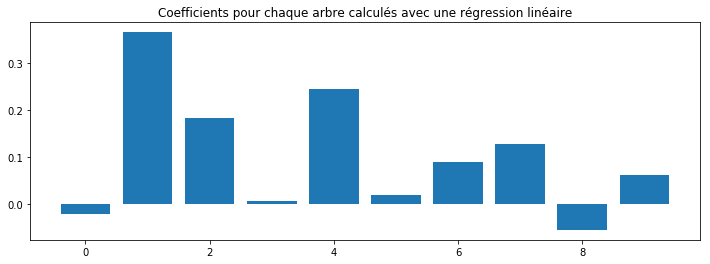

In [12]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
ax.bar(numpy.arange(0, len(lr.coef_)), lr.coef_)
ax.set_title("Coefficients pour chaque arbre calculés avec une régression linéaire");

Le score est avec une régression linéaire sur les variables initiales est nettement moins élevé.

In [13]:
lr_raw = LinearRegression()
lr_raw.fit(X_train, y_train)
r2_score(y_test, lr_raw.predict(X_test))

0.8053569683346129

## Sélection d'arbres

L'idée est d'utiliser un algorithme de sélection de variables type [Lasso](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html) pour réduire la forêt aléatoire sans perdre en performance. C'est presque le même code.

In [14]:
from sklearn.linear_model import Lasso

lrs = Lasso(max_iter=10000)
lrs.fit(X_train_2, y_train)
lrs.coef_

array([0.        , 0.35055744, 0.17865619, 0.        , 0.23928895,
       0.01243695, 0.07863688, 0.11792031, 0.        , 0.03629635])

Pas mal de zéros donc pas mal d'arbres non utilisés.

In [15]:
r2_score(y_test, lrs.predict(X_test_2))

0.8727386652135619

Pas trop de perte... Ca donne envie d'essayer plusieurs valeur de `alpha`.

In [16]:
from tqdm import tqdm
alphas = [0.01 * i for i in range(100)] +[1 + 0.1 * i for i in range(100)]
obs = []
for i in tqdm(range(0, len(alphas))):
    alpha = alphas[i]
    lrs = Lasso(max_iter=20000, alpha=alpha)
    lrs.fit(X_train_2, y_train)
    obs.append(dict(
        alpha=alpha,
        null=len(lrs.coef_[lrs.coef_!=0]),
        r2=r2_score(y_test, lrs.predict(X_test_2))
    ))

  0%|                                                                                          | 0/200 [00:00<?, ?it/s]C:\Users\m_pic\Miniconda3\lib\site-packages\ipykernel_launcher.py:7: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  import sys
C:\Users\m_pic\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:475: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
C:\Users\m_pic\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 368.43686993125345, tolerance: 3.3217130184696573
  positive)
100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 340.92it/s]


In [17]:
from pandas import DataFrame
df = DataFrame(obs)
df.tail()

,alpha,null,r2
195,10.5,6,0.872718
196,10.6,6,0.872601
197,10.7,6,0.872481
198,10.8,6,0.872358
199,10.9,6,0.872233


C:\Users\m_pic\Miniconda3\lib\site-packages\pandas\plotting\_core.py:1001: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_xlim(left, right)


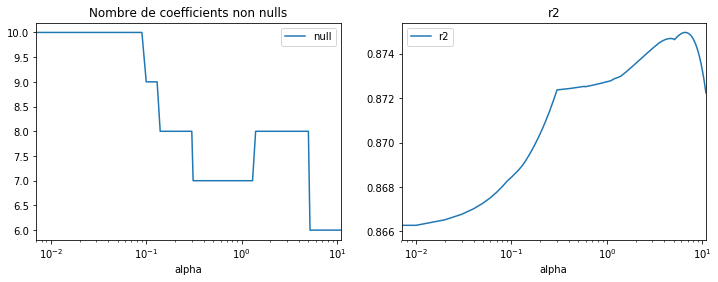

In [18]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
df[["alpha", "null"]].set_index("alpha").plot(ax=ax[0], logx=True)
ax[0].set_title("Nombre de coefficients non nulls")
df[["alpha", "r2"]].set_index("alpha").plot(ax=ax[1], logx=True)
ax[1].set_title("r2");

Dans ce cas, supprimer des arbres augmentent la performance, comme évoqué ci-dessus, cela réduit l'overfitting. Le nombre d'arbre peut être réduit des deux tiers avec ce modèle.